In [1]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn.functional as F

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Generate data with four classes
mean_class_1 = [2, 2]
cov_class_1 = [[1, 0.5], [0.5, 1]]
class_1_data = np.random.multivariate_normal(mean_class_1, cov_class_1, 100)

mean_class_2 = [-2, -2]
cov_class_2 = [[1, 0.5], [0.5, 1]]
class_2_data = np.random.multivariate_normal(mean_class_2, cov_class_2, 100)

mean_class_3 = [2, -2]
cov_class_3 = [[1, 0.5], [0.5, 1]]
class_3_data = np.random.multivariate_normal(mean_class_3, cov_class_3, 100)

mean_class_4 = [-2, 2]
cov_class_4 = [[1, 0.5], [0.5, 1]]
class_4_data = np.random.multivariate_normal(mean_class_4, cov_class_4, 100)

# Combine the four classes
X = np.vstack((class_1_data, class_2_data, class_3_data, class_4_data))
y = np.hstack((np.ones(100), np.zeros(100), 2 * np.ones(100), 3 * np.ones(100)))

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
np.random.shuffle(shuffle_idx)

X, y = X[shuffle_idx], y[shuffle_idx]
X_train, X_test = X[shuffle_idx[:320]], X[shuffle_idx[320:]]
y_train, y_test = y[shuffle_idx[:320]], y[shuffle_idx[320:]]

In [3]:
# Change train and test set to tensors
X_train_tensor=torch.tensor(X_train, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train, dtype=torch.float32)
X_test_tensor=torch.tensor(X_test, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test, dtype=torch.float32)

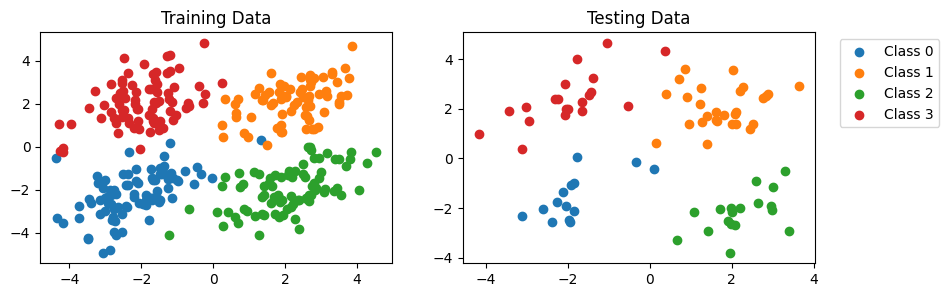

In [4]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(4):
    ax[0].scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], label=f'Class {i}')
    ax[1].scatter(X_test[y_test == i][:, 0], X_test[y_test == i][:, 1], label=f'Class {i}')

ax[0].set_title("Training Data")
ax[1].set_title("Testing Data")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
# define onehot encoding for label
def to_onehot(y, num_classes):
    y_onehot = torch.zeros(y.size(0), num_classes)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot

# define softmax
def softmax(z):
    return (torch.exp(z.t()) / torch.sum(torch.exp(z), dim=1)).t()

# define cross entropy loss
def cross_entropy(softmax, y_target):
    return - torch.sum(torch.log(softmax) * (y_target), dim=1)

In [6]:
class SoftmaxRegression():
  def __init__(self,num_features,num_classes):
    self.num_features = num_features
    self.num_classes = num_classes
    self.weights = torch.zeros(num_classes, num_features,dtype=torch.float32)   # h x m
    self.bias = torch.zeros(num_classes, dtype=torch.float32)                   # h X 1

  def forward(self, x):
        logits = torch.mm(x, self.weights.t()) + self.bias
        probas = softmax(logits)
        return logits, probas

  def backward(self, x, y, probas):
        grad_loss_weights = (-torch.mm(x.t(), y - probas).t()) / y.size(0)
        grad_loss_bias = (-torch.sum(y - probas)) / y.size(0)
        return grad_loss_weights, grad_loss_bias

  def predict_labels(self, x):
          logits, probas = self.forward(x)
          labels = torch.argmax(probas, dim=1)
          return labels

  def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy

  def train(self, x, y, num_epochs, learning_rate=0.01):

        epoch_cost = []
        for epoch in range(num_epochs):
            y_onehot = to_onehot(y, num_classes=self.num_classes)

            # Outputs
            logits, probas = self.forward(x)

            # Compute gradients
            grad_w, grad_b = self.backward(x, y_onehot, probas)

            # Update weights
            self.weights -= learning_rate * grad_w
            self.bias -= learning_rate * grad_b

            # Logging
            logits, probas = self.forward(x)
            cost = torch.mean(cross_entropy(probas, y_onehot))
            print(f'Epoch: {epoch+1} | Train ACC: {self.evaluate(x, y):.3f} | Cost: {cost:.3f}')


            epoch_cost.append(cost)
        return epoch_cost

In [7]:
model = SoftmaxRegression(num_features=2, num_classes=4)
cost=model.train(X_train_tensor, y_train_tensor,
                          num_epochs=150,
                          learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model.weights)
print('  Bias: %s' % model.bias)

Epoch: 1 | Train ACC: 0.969 | Cost: 1.180
Epoch: 2 | Train ACC: 0.969 | Cost: 1.026
Epoch: 3 | Train ACC: 0.969 | Cost: 0.908
Epoch: 4 | Train ACC: 0.966 | Cost: 0.816
Epoch: 5 | Train ACC: 0.969 | Cost: 0.743
Epoch: 6 | Train ACC: 0.969 | Cost: 0.684
Epoch: 7 | Train ACC: 0.969 | Cost: 0.635
Epoch: 8 | Train ACC: 0.969 | Cost: 0.594
Epoch: 9 | Train ACC: 0.969 | Cost: 0.559
Epoch: 10 | Train ACC: 0.969 | Cost: 0.528
Epoch: 11 | Train ACC: 0.969 | Cost: 0.502
Epoch: 12 | Train ACC: 0.969 | Cost: 0.479
Epoch: 13 | Train ACC: 0.969 | Cost: 0.458
Epoch: 14 | Train ACC: 0.969 | Cost: 0.440
Epoch: 15 | Train ACC: 0.972 | Cost: 0.423
Epoch: 16 | Train ACC: 0.972 | Cost: 0.408
Epoch: 17 | Train ACC: 0.972 | Cost: 0.395
Epoch: 18 | Train ACC: 0.972 | Cost: 0.382
Epoch: 19 | Train ACC: 0.972 | Cost: 0.371
Epoch: 20 | Train ACC: 0.972 | Cost: 0.360
Epoch: 21 | Train ACC: 0.972 | Cost: 0.351
Epoch: 22 | Train ACC: 0.972 | Cost: 0.342
Epoch: 23 | Train ACC: 0.972 | Cost: 0.333
Epoch: 24 | Train AC

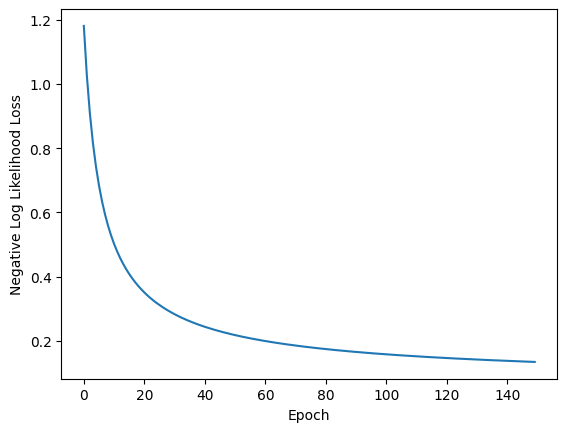

In [8]:
# Plot
plt.plot(cost)
plt.ylabel('Negative Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [9]:
test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_accuracy*100))

Test set accuracy: 97.50%


In [10]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker=markers[idx],
                    label=cl)

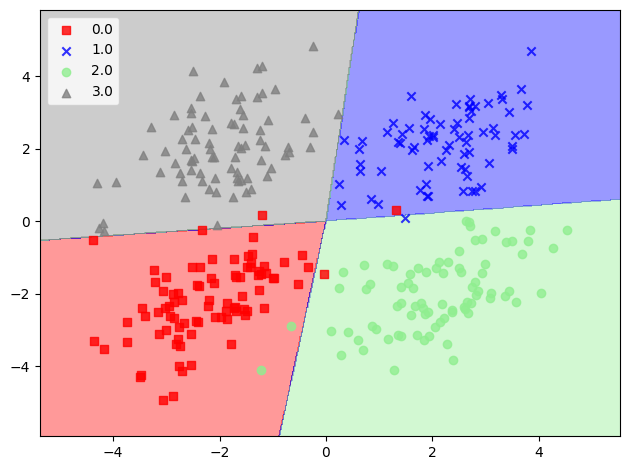

In [11]:
# Decision Boundary
plot_decision_regions(X_train_tensor, y_train_tensor, classifier=model)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()